<center>
    <h1 style="font-size:40px;">Loading and Visualizing the LiDAR Data</h1>
</center>


### Make Sure You Run the Below Command Before Running the Project


```bash
pip install -r requirements.txt


### Step 1: Loading KITTI Dataset in Python

In this section, we load the KITTI dataset which contains LiDAR point cloud frames captured from a self-driving car. These frames are essential for performing tasks like SLAM and path planning. We'll extract the LiDAR data and prepare it for visualization and processing using Python libraries such as `Open3D` and `NumPy`.


In [ ]:
import pykitti

basedir = "/home/deepak-bhagat/Downloads/data_odometry_velodyne/dataset/"

sequence = "00"

dataset = pykitti.odometry(basedir, sequence)

print(f"Loaded {len(dataset.timestamps)} frames from sequence {sequence}")


Loaded 4541 frames from sequence 00


### Step 2: Visualizing LiDAR Data

This section focuses on visualizing the raw LiDAR point clouds from the KITTI dataset. Visualizing these frames helps in understanding the structure of the surrounding environment.


In [11]:
import open3d as o3d
import numpy as np

# Load the first LiDAR frame (frame 0)
scan = dataset.get_velo(0)

# Convert to Open3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(scan[:, :3])  # Use x, y, z coordinates

# Visualize the LiDAR point cloud
o3d.visualization.draw_geometries([pcd])



<center>
    <h3 style="font-size:40px;">Implement Basic ICP SLAM</h3>
</center>


# ICP-based SLAM Explanation

## What This Code Does

- Loads **two LiDAR scans** (`pcd1` and `pcd2`).
- Uses **Iterative Closest Point (ICP)** to align `pcd2` to `pcd1`.
- Computes a **transformation matrix** that represents how `pcd2` should be moved to match `pcd1`.

## Transformation Matrix

The transformation matrix output looks like this:

\[
\begin{bmatrix} 
R_{11} & R_{12} & R_{13} & t_x \\ 
R_{21} & R_{22} & R_{23} & t_y \\ 
R_{31} & R_{32} & R_{33} & t_z \\ 
0 & 0 & 0 & 1 
\end{bmatrix}
\]

Where:
- **R** represents **rotation** (how the scan is rotated).
- **t** represents **translation** (how the scan is shifted).

## Why This is Useful

This matrix updates the robot’s **position** and **map**, helping it track movement over time. 🚀


### Step 1: Import All Required Libraries
These libraries are essential for working with point clouds, plotting, and handling files.


In [4]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  
import os


### Step 2: Define ICP SLAM Function
This function applies ICP with downsampling and normal estimation. It also skips frames with abnormal movement.


In [5]:
def icp_slam(source, target, threshold=0.5):
    """Applies Iterative Closest Point (ICP) for SLAM with preprocessing"""
    
    # Downsample
    source = source.voxel_down_sample(voxel_size=0.3)
    target = target.voxel_down_sample(voxel_size=0.3)

    # Estimate normals
    target.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=1.0, max_nn=30))

    # Run ICP
    icp = o3d.pipelines.registration.registration_icp(
        source, target, threshold, np.eye(4),
        o3d.pipelines.registration.TransformationEstimationPointToPlane(),
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=50)
    )

    # Reject large jumps
    translation = np.linalg.norm(icp.transformation[:3, 3])
    if translation > 1.5:
        print("Warning: Large transformation detected, skipping frame")
        return np.eye(4)
    
    return icp.transformation


### Step 3: Run ICP SLAM or Load Precomputed Trajectory
This section checks if the trajectory has already been saved. If not, it starts SLAM from the first frame.


In [6]:
trajectory_file = "slam_trajectory.npy"

# Load or run SLAM
if os.path.exists(trajectory_file):
    print("Loading saved SLAM trajectory...")
    trajectory = np.load(trajectory_file)
else:
    print("Running ICP-SLAM from scratch...")
    trajectory = [np.eye(4)]  # start with identity matrix

    pcd1 = o3d.geometry.PointCloud()
    pcd1.points = o3d.utility.Vector3dVector(dataset.get_velo(0)[:, :3])

    num_frames = 4541  # Total LiDAR frames in KITTI sequence

    for i in tqdm(range(1, num_frames), desc="Processing Frames"):
        pcd2 = o3d.geometry.PointCloud()
        pcd2.points = o3d.utility.Vector3dVector(dataset.get_velo(i)[:, :3])

        transformation = icp_slam(pcd1, pcd2)

        # Update pose
        trajectory.append(trajectory[-1] @ transformation)
        pcd1 = pcd2

    trajectory = np.array(trajectory)[:, :3, 3]  # extract translation part
    np.save(trajectory_file, trajectory)
    print(f"Trajectory saved to {trajectory_file}")


Loading saved SLAM trajectory...


### Step 4: Plot the SLAM Trajectory
Finally, I visualize the trajectory to understand how well the SLAM performed.


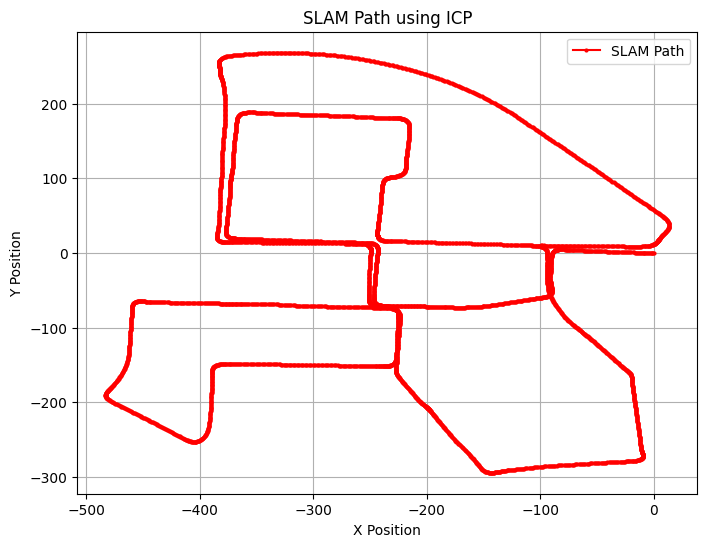

In [7]:
plt.figure(figsize=(8, 6))
plt.plot(trajectory[:, 0], trajectory[:, 1], 'ro-', markersize=2, label="SLAM Path")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("SLAM Path using ICP")
plt.legend()
plt.grid()
plt.savefig("slam_path.png")
plt.show()


### Ground Truth Path

In this section, we visualize the actual path taken by the vehicle as recorded in the KITTI dataset. This ground truth trajectory is useful for comparing the performance and accuracy of our SLAM algorithm.


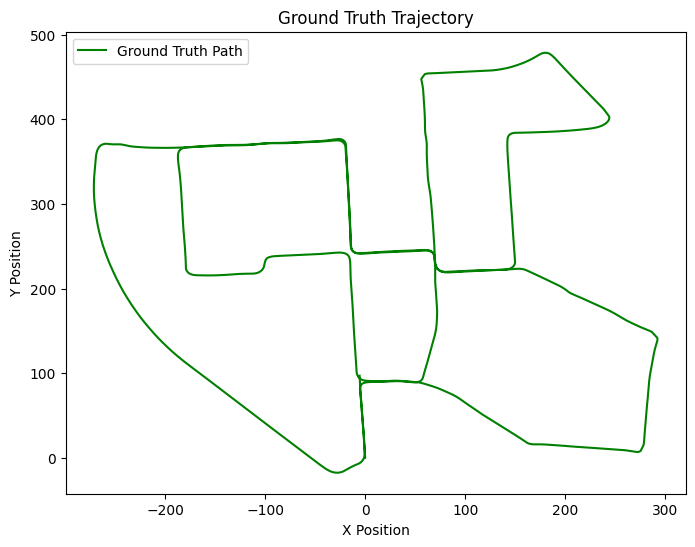

In [8]:
import numpy as np
import matplotlib.pyplot as plt


gt_poses = np.loadtxt("/home/deepak-bhagat/Downloads/data_odometry_velodyne/dataset/poses/00.txt")
gt_poses = gt_poses.reshape(-1, 3, 4)


gt_x = gt_poses[:, 0, 3]  
gt_y = gt_poses[:, 2, 3]  
gt_trajectory = np.vstack((gt_x, gt_y)).T  


plt.figure(figsize=(8, 6))
plt.plot(gt_trajectory[:, 0], gt_trajectory[:, 1], 'g-', label='Ground Truth Path')

plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.title("Ground Truth Trajectory")
plt.show()


### SLAM vs Ground Path

- **SLAM Path**: Generated by the ICP algorithm using LiDAR scans, approximating the vehicle's movement. It may have small errors due to sensor noise and ICP limitations.
  
- **Ground Truth Path**: The actual path of the vehicle, obtained from high-precision tracking systems like GPS. It serves as a reference for validating SLAM accuracy.

### Comparison:
- **SLAM Path** approximates the **Ground Truth Path** but may contain small errors.
- The goal is to minimize the difference between these paths, indicating SLAM's accuracy.



/tmp/ipykernel_2227479/3840640138.py:46: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(trajectory[:, 0], trajectory[:, 1], 'r-', marker='o', linestyle='-', label='SLAM Path')


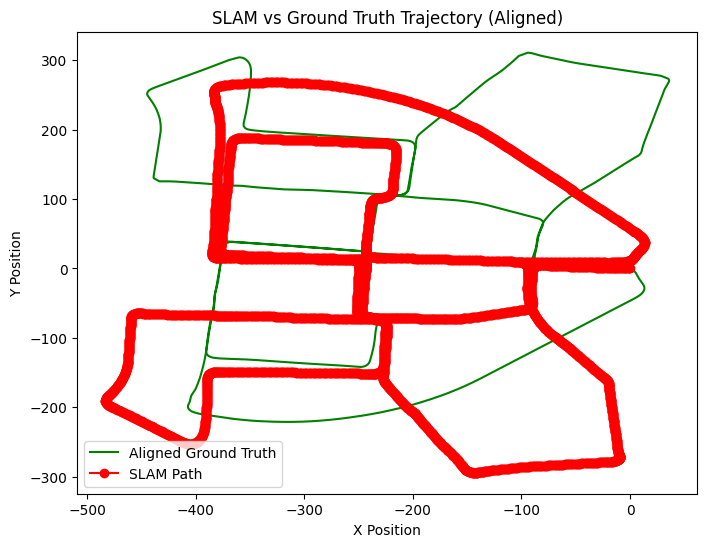

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def rotate_trajectory(points, angle):
    """
    Rotates the given trajectory by a specified angle.

    Parameters:
        points (numpy.ndarray): (N, 2) array of (x, y) coordinates.
        angle (float): Rotation angle in radians.

    Returns:
        numpy.ndarray: Rotated trajectory.
    """
    R = np.array([[np.cos(angle), -np.sin(angle)], 
                  [np.sin(angle), np.cos(angle)]])
    return points @ R.T  


gt_poses = np.loadtxt("/home/deepak-bhagat/Downloads/data_odometry_velodyne/dataset/poses/00.txt")
gt_poses = gt_poses.reshape(-1, 3, 4)


gt_x = gt_poses[:, 0, 3]  
gt_y = gt_poses[:, 2, 3]  
gt_trajectory = np.vstack((gt_x, gt_y)).T  


trajectory = np.array(trajectory)  
trajectory = trajectory[:, :2]  


angle = np.arctan2(trajectory[-1, 1] - trajectory[0, 1], trajectory[-1, 0] - trajectory[0, 0]) - \
        np.arctan2(gt_trajectory[-1, 1] - gt_trajectory[0, 1], gt_trajectory[-1, 0] - gt_trajectory[0, 0])


rotated_gt_trajectory = rotate_trajectory(gt_trajectory, angle)


translation = trajectory[0] - rotated_gt_trajectory[0]  
rotated_gt_trajectory += translation  


plt.figure(figsize=(8, 6))
plt.plot(rotated_gt_trajectory[:, 0], rotated_gt_trajectory[:, 1], 'g-', label='Aligned Ground Truth')
plt.plot(trajectory[:, 0], trajectory[:, 1], 'r-', marker='o', linestyle='-', label='SLAM Path')

plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.title("SLAM vs Ground Truth Trajectory (Aligned)")
plt.show()


# A* Pathfinding on LiDAR 3D Point Cloud

In this part, we implemented **A\* pathfinding** on a 3D point cloud generated from LiDAR data to find the shortest path between a start and goal point in a 3D space.

## Steps

### 1. **Loading and Preprocessing LiDAR Data**
- The LiDAR point cloud data is loaded and grayscale colors are assigned based on the height (Z-axis) to improve visualization.

### 2. **Discovered Region Masking**
- A height threshold is applied to filter out points that are below a certain level, focusing on the discovered regions of the environment.

### 3. **Selecting Start and Goal Points**
- A random start point is chosen, and then a nearby goal point is selected within 100 units of the start point.

### 4. **Voxelization**
- The point cloud is converted into a voxel grid for easier processing. A **KDTree** is used to find the nearest neighbors for the pathfinding process.

### 5. **A* Search**
- The **A\* algorithm** is used to compute the shortest path between the start and goal points, avoiding obstacles in the environment.

### 6. **Visualization**
- Using **Open3D**, we visualize the point cloud, marking the start and goal points with spheres and the computed path with line segments.

## Results
The pathfinding works by navigating through the discovered 3D space and is fully visualized in the 3D environment using Open3D.


In [12]:
import open3d as o3d
import numpy as np
import heapq
from scipy.spatial import KDTree
import random

# Load point cloud (assumes you already have dataset loaded with get_velo)
scan = dataset.get_velo(0)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(scan[:, :3])

# Optional: Assign grayscale color based on height (Z-axis) for visualization
z = scan[:, 2]
min_z, max_z = z.min(), z.max()
normalized_z = (z - min_z) / (max_z - min_z)
colors = np.tile(normalized_z.reshape(-1, 1), (1, 3))
pcd.colors = o3d.utility.Vector3dVector(colors)

# Use height-based mask to filter discovered regions
points = np.asarray(pcd.points)
discovered_mask = points[:, 2] > -2.0  # Adjust threshold if needed
discovered_points = points[discovered_mask]

if len(discovered_points) == 0:
    raise Exception("❌ No discovered region found in point cloud.")

# Choose a random start point
start_world = discovered_points[random.randint(0, len(discovered_points)-1)]

# Choose a goal point near the start (within 100 units)
nearby_points = discovered_points[
    np.linalg.norm(discovered_points - start_world, axis=1) < 100
]
if len(nearby_points) == 0:
    raise Exception("❌ No goal candidates found within 100 units of start point.")

goal_world = nearby_points[random.randint(0, len(nearby_points)-1)]

# Voxelization
voxel_size = 0.5
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd, voxel_size=voxel_size)
origin = voxel_grid.origin
vs = voxel_grid.voxel_size
occupied_voxels = [tuple(voxel.grid_index) for voxel in voxel_grid.get_voxels()]
occupied_set = set(occupied_voxels)
occupied_array = np.array(occupied_voxels)
kdtree = KDTree(occupied_array)

# Conversion helpers

def point_to_voxel(point):
    """
    Converts a 3D point in world coordinates to its corresponding voxel index.

    Args:
    - point: 3D coordinates of the point (x, y, z).
    
    Returns:
    - Tuple of voxel indices (x_voxel, y_voxel, z_voxel).
    """
    return tuple(((np.array(point) - origin) / vs).astype(int))

def voxel_to_point(index):
    """
    Converts a voxel index back to the corresponding 3D world point.

    Args:
    - index: Tuple of voxel indices (x_voxel, y_voxel, z_voxel).
    
    Returns:
    - 3D coordinates of the point in world space.
    """
    return np.array(index) * vs + origin + vs / 2

def find_nearest_valid_voxel(voxel):
    """
    Finds the nearest discovered voxel if the current voxel is not discovered.

    Args:
    - voxel: Voxel index to check.
    
    Returns:
    - Nearest discovered voxel index.
    """
    if voxel in occupied_set:
        return voxel
    dist, idx = kdtree.query(np.array(voxel))
    nearest_voxel = tuple(occupied_array[idx])
    print(f"⚠️ Voxel {voxel} not discovered. Using nearest discovered voxel: {nearest_voxel}")
    return nearest_voxel

# Convert and validate
start_voxel_raw = point_to_voxel(start_world)
goal_voxel_raw = point_to_voxel(goal_world)
start_voxel = find_nearest_valid_voxel(start_voxel_raw)
goal_voxel = find_nearest_valid_voxel(goal_voxel_raw)

# Print start and goal voxel information
print("✅ Start voxel:", start_voxel)
print("✅ Goal voxel:", goal_voxel)

# A* Search
def heuristic(a, b):
    """
    Heuristic function for A* search, computes the Euclidean distance between two points.

    Args:
    - a: Start point (x, y, z).
    - b: Goal point (x, y, z).
    
    Returns:
    - Euclidean distance between points a and b.
    """
    return np.linalg.norm(np.array(a) - np.array(b))

def get_neighbors(node):
    """
    Generates neighboring voxels in a 3x3x3 grid around the current voxel.

    Args:
    - node: Current voxel (x, y, z).
    
    Yields:
    - Neighboring voxel coordinates.
    """
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            for dz in [-1, 0, 1]:
                if dx == dy == dz == 0:
                    continue
                yield (node[0]+dx, node[1]+dy, node[2]+dz)

def astar(start, goal):
    """
    Implements the A* algorithm to find the shortest path between start and goal voxels.

    Args:
    - start: Start voxel index (x_voxel, y_voxel, z_voxel).
    - goal: Goal voxel index (x_voxel, y_voxel, z_voxel).
    
    Returns:
    - List of voxels representing the path from start to goal, or None if no path is found.
    """
    open_set = []
    heapq.heappush(open_set, (heuristic(start, goal), 0, start))
    came_from = {}
    g_score = {start: 0}

    while open_set:
        _, cost, current = heapq.heappop(open_set)
        if current == goal:
            path = [current]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            return path[::-1]

        for neighbor in get_neighbors(current):
            if neighbor not in occupied_set:
                continue
            tentative_g_score = g_score[current] + heuristic(current, neighbor)
            if neighbor not in g_score or tentative_g_score < g_score[neighbor]:
                g_score[neighbor] = tentative_g_score
                f_score = tentative_g_score + heuristic(neighbor, goal)
                heapq.heappush(open_set, (f_score, tentative_g_score, neighbor))
                came_from[neighbor] = current
    return None

# Run A*
path = astar(start_voxel, goal_voxel)

# Helper: Make sphere for marking points
def make_sphere(center, color):
    """
    Creates a sphere to mark a point in the visualization.

    Args:
    - center: 3D coordinates of the sphere center (x, y, z).
    - color: RGB color values for the sphere.
    
    Returns:
    - A sphere geometry to be added to the visualization.
    """
    sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.5)
    sphere.translate(center)
    sphere.paint_uniform_color(color)
    return sphere

# Markers for start and goal
start_point = voxel_to_point(start_voxel)
goal_point = voxel_to_point(goal_voxel)
start_sphere = make_sphere(start_point, [0, 1, 0])  # Green
goal_sphere = make_sphere(goal_point, [1, 0, 0])    # Red

# Add geometries to the visualization
geometries = [pcd, start_sphere, goal_sphere]

# Visualize path
if path is None:
    print("⚠️ No path found.")
else:
    print("✅ Path found! Length:", len(path))
    path_points = [voxel_to_point(p) for p in path]
    path_line_set = o3d.geometry.LineSet()
    path_line_set.points = o3d.utility.Vector3dVector(path_points)
    path_line_set.lines = o3d.utility.Vector2iVector([[i, i+1] for i in range(len(path_points)-1)])
    geometries.append(path_line_set)

# Draw everything
o3d.visualization.draw_geometries(geometries)


✅ Start voxel: (np.int64(151), np.int64(119), np.int64(19))
✅ Goal voxel: (np.int64(149), np.int64(79), np.int64(21))
✅ Path found! Length: 42
